# Análise exploratória dos títulos presentes na Netflix

O objetivo desse mini-projeto é a visualização e compreensão do conjunto de dados em questão que representa os filmes e programas de TV disponíveis na Netflix.  

Esse conjunto de dados foi obtido na plataforma Kaggle:


*   https://www.kaggle.com/shivamb/netflix-shows





Para que seja possível realizar essa análise, será necessário utilizar um conjunto de ferramentas que auxilirão em todo processo. São elas: 

* Pandas: biblioteca que possibilitará a manipulação e análise dos dados. 

* Plotly, Matplotlib, Seaborn: bibliotecas gráficas para visualização de dados.






In [ ]:
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter 
import plotly.graph_objects as go
import plotly.express as exp 

O primeiro passo a ser dado é fazer a leitura da nossa base de dados. Nesse caso, ela foi disponibilizada no formato '.csv' e a utilizaremos de forma local, ou seja, é necessário fazer o upload do arquivo antes de executar as células do colab. 

In [50]:
netflix_data = pd.read_csv('netflix_titles.csv')
netflix_data

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


Após visualizar rapidamente como é composto nosso conjunto de dados, podemos extrair algumas informações sobre ele rapidamente.

In [51]:
netflix_data.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

## O que significa cada coluna?

* ```show_id```: código de identificação de cada título.
* ```type```: identifica qual o tipo do título, se é um filme ou um programa de tv.
* ```title```: nome do título.
* ```director```: diretor ou diretores do filme ou programa de TV.
* ```cast```: elenco.
* ```country```: país origem.
* ```date_added```: data em que foi adicionado a Netflix.
* ```release_year```: ano de lançamento.
* ```rating```: classificação do título
* ```duration```: duração em minutos para o caso dos filmes e em temporadas para os programas de TV. 
* ```listed_in```: categoria do título.
* ```description```: sinopse. 


In [52]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


## Identificando valores nulos no conjunto de dados


In [53]:
#Identificando quantos valores núlos cada coluna possui
netflix_data.isnull().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

# Preparação dos dados

Nessa etapa, realizaremos transformações que facilitarão a análise dos dados, dentre elas a remoção de colunas desnecessárias, tratamento de strings e datas, etc.

A primeira mudança constituirá na remoção da coluna ```show_id```, isso porque não será necessário manter identificadores únicos para esse caso. 



In [54]:
netflix_data = netflix_data.drop(labels=['show_id'], axis=1)

A coluna ```date_added``` que representa quando o título foi adicionado no catalogo da Netflix, está no formato de ```string``` e para tornar esse campo mais fácil de usar, realizaremos a conversão para o tipo ```datetime```, usando da função do pandas: ```to_datetime()```

Além disso, isolaremos tanto o mês quanto o ano em novas colunas do DataFrame.




In [55]:
## add new features in the dataset
netflix_data["date_added"] = pd.to_datetime(netflix_data['date_added'])
netflix_data['year_added'] = netflix_data['date_added'].dt.year
netflix_data['month_added'] = netflix_data['date_added'].dt.month

Outras duas mudanças que podem ser feitas dizem respeito a coluna ```duration```, nela temos a descrição do tempo sendo feita com valores em minutos ou com a quantidade de temporadas, por exemplo, "90 min" ou "3 Seasons", porém, em termos de analise possuir esses dados no formato de ```string``` não é vantajoso. E para tratar disso, utilizaremos os recursos: 
 * ```apply()```: Possibilita aplicar uma função em um eixo do dataframe;
 * ```split()```: Vai dividir a string quando encontrar o caracter passado; 

A primeira mudança diz respeito a criação de uma nova coluna: ```season_count```, ela conterá apenas o valor númerico correspondente a  quantidade de temporadas de cada série ou programa de TV. 

E a segunda mudança é a remoção da unidade "min" na coluna ```duration```


In [56]:
netflix_data['season_count'] = netflix_data.apply(
    lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else "",
     axis = 1)

netflix_data['duration'] = netflix_data.apply(
    lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "",
     axis = 1)

Após realizadas essas transformações os valores das linhas nas colunas ```duration``` e  ```season_count``` ainda são ```strings``` e para que possamos mudar isso, utilizaremos a função do pandas: ```to_numeric()``` que será responsável por transformar toda a coluna em valores númericos.

Além disso, as posições vazias dessa coluna estão definidas como `strings` vazias e para facilitar o tratamento desses valores ausentes utilizaremos a função `replace()` para substituir esses valores por `NaN` e com isso poderemos remover os valores faltantes de forma mais simples. 

In [57]:
netflix_data['duration'] = pd.to_numeric(netflix_data['duration'].replace("", np.NaN))
netflix_data['season_count'] = pd.to_numeric(netflix_data['season_count'].replace("", np.NaN))


In [58]:
netflix_data.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,season_count
0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90.0,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019.0,9.0,NaN
1,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94.0,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016.0,9.0,NaN
2,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,NaN,Kids' TV,"With the help of three human allies, the Autob...",2018.0,9.0,1.0
3,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,NaN,Kids' TV,When a prison ship crash unleashes hundreds of...,2018.0,9.0,1.0
4,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99.0,Comedies,When nerdy high schooler Dani finally attracts...,2017.0,9.0,NaN


# Divisão do conteúdo da Netflix



In [59]:
movie = netflix_data.filter(items=['type', 'year_added']).loc[netflix_data['type'] == 'Movie'].dropna()
tv_show = netflix_data.filter(items=['type', 'year_added']).loc[netflix_data['type'] == 'TV Show'].dropna()

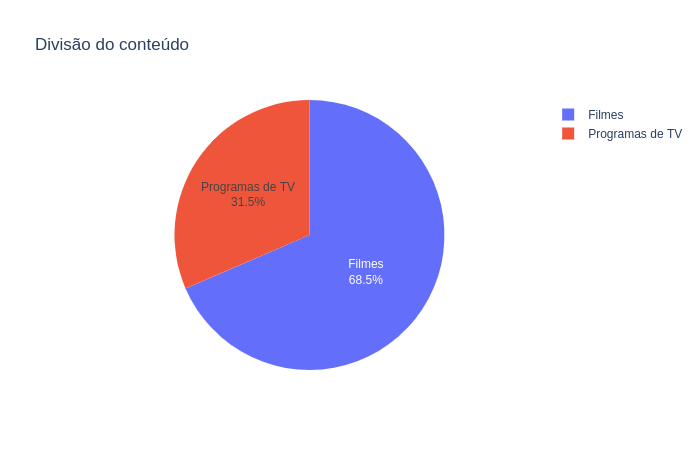

In [60]:
fig = go.Figure(data=[go.Pie(labels=['Filmes', 'Programas de TV'], values= [movie['type'].count(),
                                                                            tv_show['type'].count()],
                             textinfo='label+percent')], layout=go.Layout(title="Divisão do conteúdo"))
fig.show("png")

# Crescimento dos filmes e programas de TV ao longo dos anos.

O crescimento será analisado com base no ano em que foi adicionado ao catalogo da Netflix (`date_added`)

In [61]:
moviesByYearAdded = movie['year_added'].value_counts().reset_index().rename(columns={'year_added': 'count', 'index': 'year'})
moviesByYearAdded = moviesByYearAdded.sort_values(by=['year'], ascending=True)

tvShowByYearAdded = tv_show['year_added'].value_counts().reset_index().rename(columns={'year_added': 'count', 'index': 'year'})
tvShowByYearAdded = tvShowByYearAdded.sort_values(by=['year'], ascending=True)

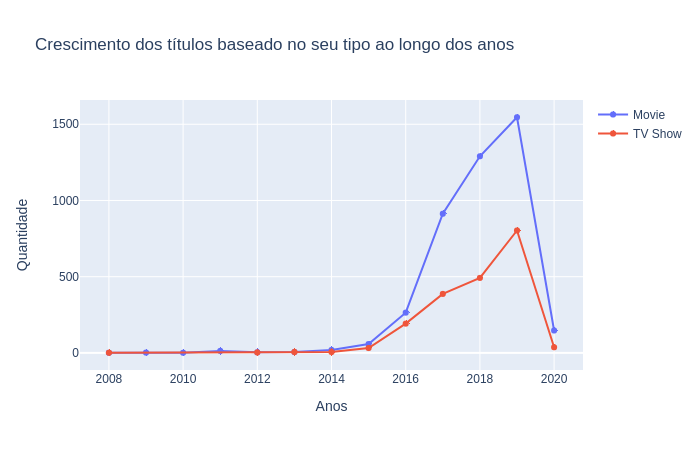

In [66]:
moviePlot = go.Scatter(x=moviesByYearAdded['year'], y=moviesByYearAdded['count'], name = "Movie")
tvshowPlot = go.Scatter(x=tvShowByYearAdded['year'], y = tvShowByYearAdded['count'], name = "TV Show")


layout = go.Layout(
    title = "Crescimento dos títulos baseado no seu tipo ao longo dos anos",
    xaxis_title = "Anos",
    yaxis_title = "Quantidade",
)

fig = go.Figure(data = [moviePlot, tvshowPlot] , layout = layout)
fig.show("png")


# Como são as durações dos filmes e dos programas de TV na Netflix?


### Filmes

In [67]:
duration_movie = netflix_data['duration'].dropna()

In [68]:
duration_movie.describe(include='all')

count    4265.000000
mean       99.100821
std        28.074857
min         3.000000
25%        86.000000
50%        98.000000
75%       115.000000
max       312.000000
Name: duration, dtype: float64

In [69]:
print("Duração total: ", round(duration_movie.sum()/60,2), "horas")

Duração total:  7044.42 horas


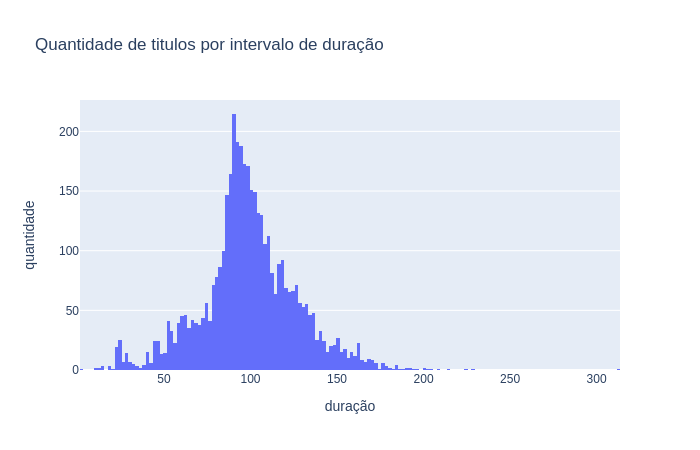

In [70]:
fig = exp.histogram(netflix_data['duration'], x="duration", title = "Quantidade de titulos por intervalo de duração" )
fig.update_layout(
    xaxis_title = "duração",
    yaxis_title = "quantidade",
)
fig.show("png")

### Programas de TV

In [71]:
tvshow_duration = netflix_data['season_count'].dropna()

In [72]:
tvshow_duration.describe(include='all')

count    1969.000000
mean        1.779584
std         1.624936
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        15.000000
Name: season_count, dtype: float64

In [73]:
print("Duração total: ", round(tvshow_duration.sum(),2), "temporadas")

Duração total:  3504.0 temporadas


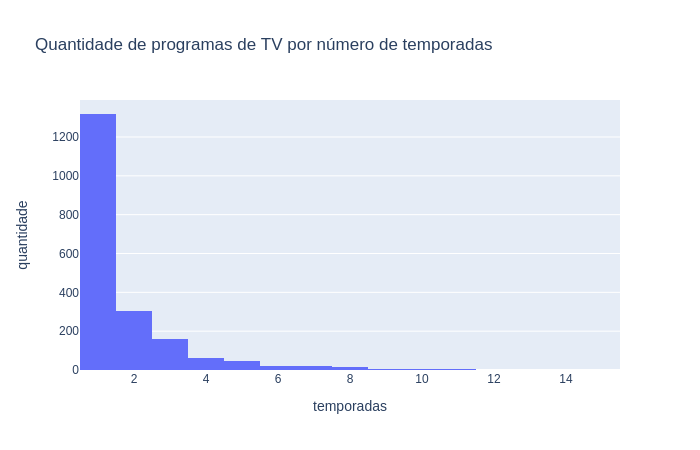

In [74]:
fig = exp.histogram(netflix_data['season_count'], x = "season_count",
                    title = "Quantidade de programas de TV por número de temporadas")
fig.update_layout(
    xaxis_title = "temporadas",
    yaxis_title = "quantidade",
)
fig.show("png")

# Distribuição dos títulos com base na classificação

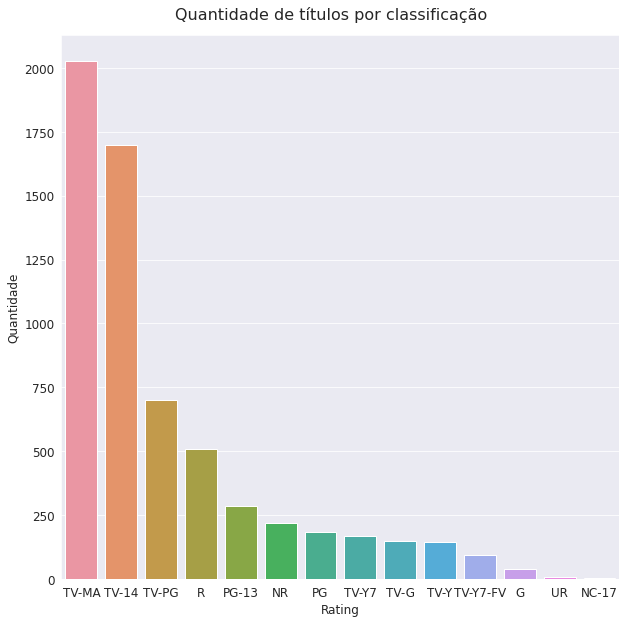

In [27]:
titlesByRating = netflix_data.copy()
titlesByRating = titlesByRating['rating'].value_counts().reset_index().rename(columns={'index': 'rating', 'rating': 'count'})
titlesByRating
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style(style="darkgrid")
ax = sns.barplot(x=titlesByRating['rating'], y = titlesByRating['count'], data=titlesByRating)
ax.tick_params(labelsize=12) #Ajustando ticklabels para uma fonte maior. 
ax.set_xlabel("Rating", fontsize = 12)
ax.set_ylabel("Quantidade", fontsize = 12)
fig.suptitle("Quantidade de títulos por classificação", fontsize = 16, y = 0.92)
plt.show()

# Quantidade de títulos por país

In [75]:
'''
    Essa função irá "quebrar" as Series que possuem múltiplos valores em suas linhas, transformando toda linha em valor único
    Dessa forma será possível análisar, por exemplo, todos os possíveis diretores, atores, atrizes, etc.
'''
def transformColumn(serie):
  new_serie = []
  for i in serie: 
   if (len(i) > 1): #Verifica se há mais de um autor por título
     for j in i:
       new_serie.append(j.strip()) #Insere individualmente cada diretor re
   else:
     new_serie.append(i[0])

  new_serie = pd.Series(data=new_serie)
  return new_serie


In [76]:
netflixDataCopy = netflix_data.copy()
titlesByCountry = netflix_data['country'].dropna()

titlesByCountry = titlesByCountry.apply(lambda x: x.split(","))
titlesByCountry = transformColumn(titlesByCountry)
titlesByCountry = titlesByCountry.value_counts().reset_index().rename(columns={"index": "country", 0: "count"})[0:20]



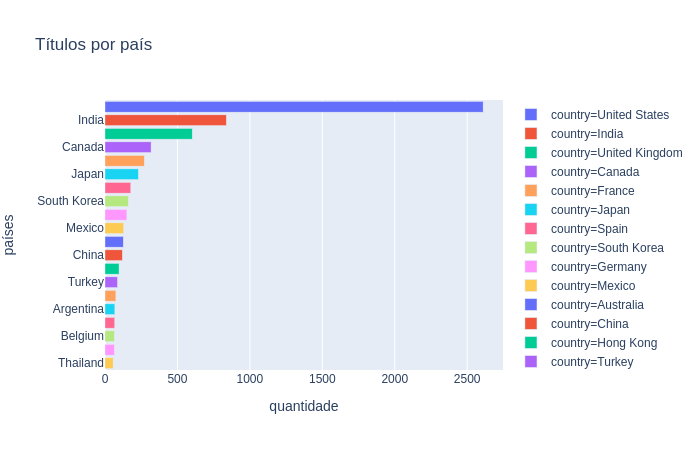

In [77]:
fig = exp.bar(x=titlesByCountry['count'], y = titlesByCountry['country'], orientation='h',
              data_frame=titlesByCountry,
              color='country', title="Títulos por país")
fig.update_layout(dict(xaxis_title="quantidade", yaxis_title="países",
                      ))
fig.show("png")

# Como foi o crescimentos dos títulos em um conjunto de países? 

Para responder essa pergunta é necessário definir um conjunto de países e uma escala de tempo para a análise. Serão avaliados 4 países dentro do intervalo de tempo de 2000 até 2020. Sendo que será considerado o ano de lançamento.

E colocaremos em foco 4 países:

* Estados Unidos
* India
* Reino Unido
* Brasil 

In [78]:
increaseTitlesNetflix = netflix_data.copy()
increaseTitlesNetflix = increaseTitlesNetflix.filter(items=['country', 'release_year'])
increaseTitlesNetflix = increaseTitlesNetflix.loc[(increaseTitlesNetflix['country'].isin(['Brazil', 'United States',
                                                                                          'United Kingdom',
                                                                                          'India']))]
                                                                                        

increaseTitlesNetflix = increaseTitlesNetflix.dropna()
increaseTitlesNetflix = increaseTitlesNetflix.loc[increaseTitlesNetflix['release_year'] >= 2000]

In [79]:
brazilianTitlesByReleaseYear = increaseTitlesNetflix.loc[increaseTitlesNetflix['country'] == 'Brazil']

brazilianTitlesByReleaseYear = brazilianTitlesByReleaseYear['release_year'].value_counts().reset_index().rename(
    columns={'index': 'release_year', 'release_year': 'count'})

brazilianTitlesByReleaseYear = brazilianTitlesByReleaseYear.sort_values(by=['release_year'], ascending=True)


In [80]:
UnitedStatesTitlesByReleaseYear = increaseTitlesNetflix.loc[increaseTitlesNetflix['country'] == 'United States']

UnitedStatesTitlesByReleaseYear = UnitedStatesTitlesByReleaseYear['release_year'].value_counts().reset_index().rename(
    columns={'index': 'release_year', 'release_year': 'count'})
UnitedStatesTitlesByReleaseYear = UnitedStatesTitlesByReleaseYear.sort_values(by=['release_year'], ascending=True)


In [81]:
UKTitlesByReleaseYear = increaseTitlesNetflix.loc[increaseTitlesNetflix['country'] == 'United Kingdom']

UKTitlesByReleaseYear = UKTitlesByReleaseYear['release_year'].value_counts().reset_index().rename(
    columns={'index': 'release_year', 'release_year': 'count'})
UKTitlesByReleaseYear = UKTitlesByReleaseYear.sort_values(by=['release_year'], ascending=True)

In [82]:
indiaTitlesByReleaseYear = increaseTitlesNetflix.loc[increaseTitlesNetflix['country'] == 'India']

indiaTitlesByReleaseYear = indiaTitlesByReleaseYear['release_year'].value_counts().reset_index().rename(
    columns={'index': 'release_year', 'release_year': 'count'})
netflix_data
indiaTitlesByReleaseYear = indiaTitlesByReleaseYear.sort_values(by=['release_year'], ascending=True)


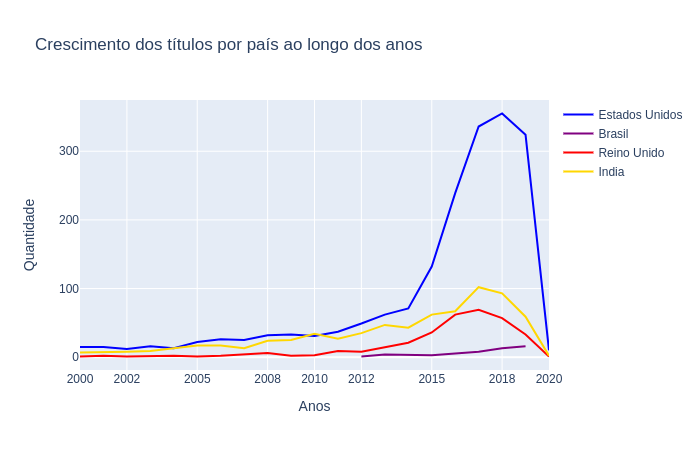

In [83]:
unitedStatesPlot = go.Scatter(x = UnitedStatesTitlesByReleaseYear['release_year'],
                                     y =UnitedStatesTitlesByReleaseYear['count'],
                                     marker=dict(color='blue'),name = "Estados Unidos", mode = 'lines')

brazilPlot = go.Scatter(x = brazilianTitlesByReleaseYear['release_year'],
                                     y =brazilianTitlesByReleaseYear['count'],
                                     marker=dict(color='purple'),name = "Brasil", mode ='lines')

ukPlot = go.Scatter(x = UKTitlesByReleaseYear['release_year'],
                                     y = UKTitlesByReleaseYear['count'],
                                     marker=dict(color='red'),  name = "Reino Unido", mode = 'lines')

indiaPlot = go.Scatter(x = indiaTitlesByReleaseYear['release_year'],
                                     y = indiaTitlesByReleaseYear['count'],
                                     marker=dict(color='gold'), name = "India", mode = 'lines')

dataPlot = [unitedStatesPlot, brazilPlot, ukPlot, indiaPlot]

layout = go.Layout(
    title = 'Crescimento dos títulos por país ao longo dos anos',
    xaxis_title = "Anos",
    yaxis_title = "Quantidade", 
    xaxis = dict(tickvals=[2000, 2002, 2005, 2008, 2010, 2012, 2015, 2018, 2020]),
)
fig = go.Figure(data=dataPlot, layout=layout)

fig.show("png")

# Quantidade de títulos por diretor


In [84]:
#Preparação da lista de diretores
directors = netflix_data['director'].dropna()

directors = directors.apply(lambda x : x.split(","))

#Responsável por transformar os elementos que são listas em novos elementos
new_serie = transformColumn(directors)
new_serie = new_serie.value_counts()

directors_df = pd.DataFrame()
directors_df['director'] = new_serie
directors_df = directors_df.reset_index().rename(columns={'director': 'count', "index": "director"})
directors_df = directors_df[0:30]


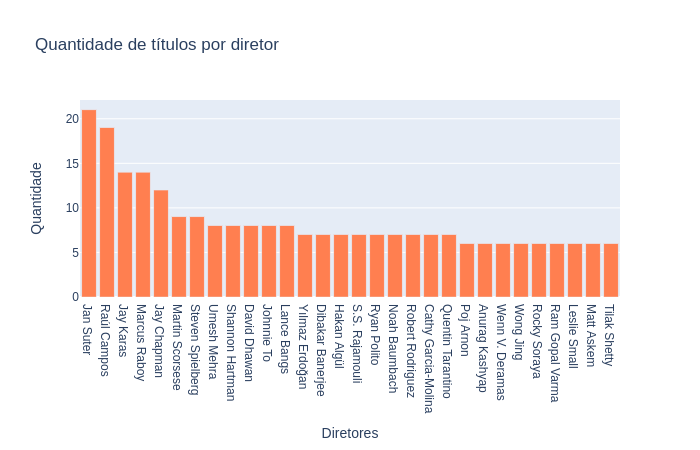

In [85]:
bar1 = go.Bar(x = directors_df['director'], y=directors_df['count'],  orientation='v', 
               marker={'color': 'coral'})

layout = go.Layout(
    title="Quantidade de títulos por diretor",
    xaxis_title= "Diretores",
    yaxis_title = "Quantidade",
)

fig = go.Figure(data= bar1, layout=layout)
fig.show("png")

# Quais são os gêneros presentes na Netflix?


In [86]:
gender = netflix_data['listed_in']
gender = gender.apply(lambda x: x.split(","))
gender = transformColumn(gender)
gender = gender.value_counts().reset_index().rename(columns={"index": "gender", 0: "count"})[0:20]


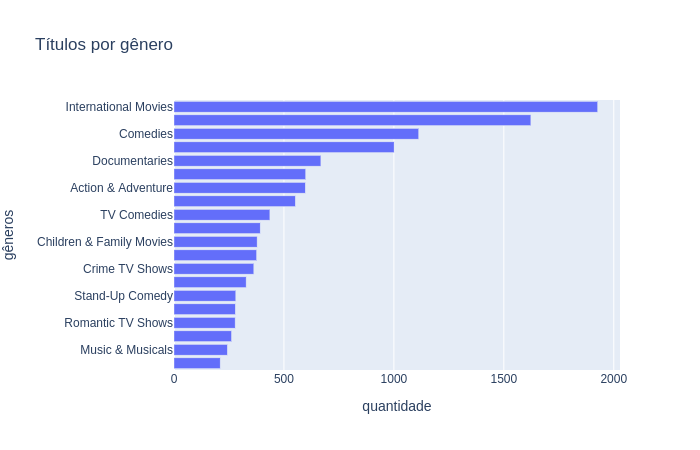

In [87]:
plot = go.Bar(x=gender['count'], y=gender['gender'], orientation='h')
layout = go.Layout(
    title = "Títulos por gênero",
    xaxis_title = "quantidade",
    yaxis_title = "gêneros",
  
)
fig = go.Figure(data=plot, layout=layout)
fig.update_yaxes(autorange='reversed')
fig.show("png")

# Atores com mais filmes na Netflix


In [88]:
def actorsByCountryTrace(country):
  actorsData = netflix_data.copy()
  aux = pd.Series(dtype='object')
  actorsData = actorsData.filter(items=['cast', 'country', 'type']).dropna()
  
  actorsData = actorsData.loc[(actorsData['country'] == country) & (actorsData['type'] == "Movie")]
 
  newActorsData = actorsData['cast'].apply(lambda x: x.split(","))
  
  newActorsData = transformColumn(newActorsData)
  newActorsData = newActorsData.value_counts().reset_index().rename(columns={"index": "actor", 0:'count'})[0:20]
  
  return go.Bar(x=newActorsData['count'], y = newActorsData['actor'],
                orientation='h',marker=dict(color="#355070"), name = "".format(country))

In [89]:
traces = []
countries = ['United States', 'United Kingdom', 'India', 'Japan', 'Canada']
COLORS = ['moccasin', 'mediumpurple', 'darkblue', 'deepskyblue', 'antiquewhite']

for country in countries: 
  traces.append(actorsByCountryTrace(country))

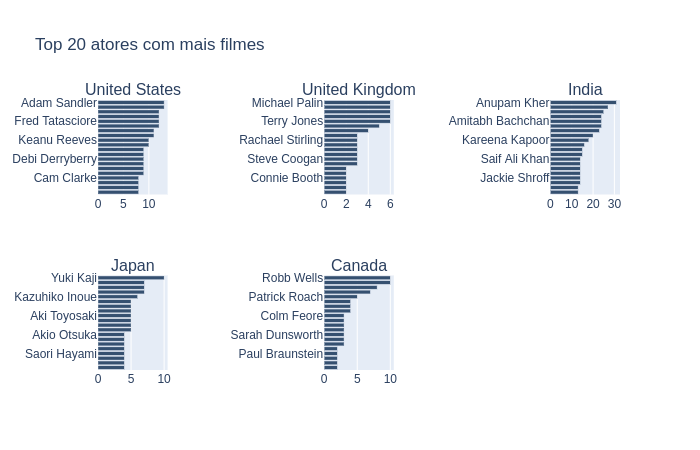

In [91]:
from plotly.subplots import make_subplots
fig = make_subplots(rows = 2, cols= 3, subplot_titles=countries, horizontal_spacing=0.3, vertical_spacing=0.3)

fig.add_trace(traces[0], row=1, col=1)
fig.add_trace(traces[1], row=1, col=2)
fig.add_trace(traces[2], row=1, col=3)
fig.add_trace(traces[3], row=2, col=1)
fig.add_trace(traces[4], row=2, col=2)

fig.update_layout(height=1200, showlegend=False, title='Top 20 atores com mais filmes')
fig.update_yaxes(autorange='reversed')
fig.show("png")